# Batching + Frame Skipping

In [1]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython import display
from pathlib import Path
from time import time
from JAVER.track_tools import FrameHandler, FaceTracker

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Get a sample video

We begin by loading a video with some faces in it. 

In [7]:
video_path = '../../tests/data/Elon Musk/sample_short.mp4'
display.Video(video_path, width=640)

## Init FaceTracker from JAVER

In [3]:
%%time

p = Path("../../tests/data/Elon Musk/")
ref_paths = list(p.glob("inliers/*"))
    
face_tracker = FaceTracker(
    image_size=160, 
    ref_paths=ref_paths, 
    batch_size=30, 
    step_large=10, 
    step_small=5
)

CPU times: user 8.06 s, sys: 196 ms, total: 8.26 s
Wall time: 4.94 s


## Run video through mtcnn with FaceTracker

In [4]:
# shut up loggers
import logging
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel("CRITICAL") 

In [6]:
%%time

faces_dict = face_tracker.detect(video_path)

CPU times: user 1min 4s, sys: 6.44 s, total: 1min 11s
Wall time: 37.3 s


## Draw Faces

In [37]:
video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

In [8]:
%%time

frames_tracked = []
for i, frame in enumerate(frames):
    
    faces = faces_dict[i]
    
    boxes = [face.bbox for face in faces]
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    
    if boxes is None:
        continue
    for box in boxes:
            draw.rectangle(box, outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))

CPU times: user 19 s, sys: 1.33 s, total: 20.3 s
Wall time: 20.3 s


## Display detections

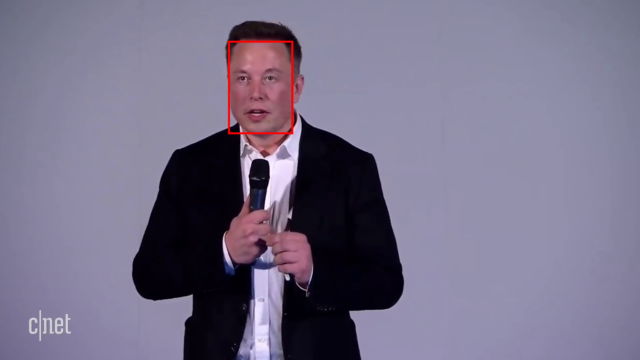

In [9]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

## Compare step sizes

In [5]:
logging.getLogger('JAVER.logger').setLevel("ERROR") 

In [8]:
small_step_sizes = range(1, 20, 2)
large_step_muls = [2, 5, 10]

times = np.zeros((len(large_step_muls), len(small_step_sizes)))

face_tracker = FaceTracker(
    image_size=160, 
    ref_paths=ref_paths, 
    batch_size=8, 
    step_large=0, 
    step_small=0
)

for n, large_step_mul in enumerate(large_step_muls):
    for m, small_step in enumerate(small_step_sizes): 
        large_step = small_step * large_step_mul
        if small_step == large_step:
            continue
            
        face_tracker.step_small = small_step
        face_tracker.step_large = large_step
        
        start_time = time()
        faces_dict = face_tracker.detect(video_path)

        end_time = time()
        times[n,m] = end_time - start_time
        print(f'small: {small_step}, large: {large_step}, time: {times[n,m]}')

small: 1, large: 2, time: 117.44392776489258
small: 3, large: 6, time: 47.13683533668518
small: 5, large: 10, time: 32.7513644695282
small: 7, large: 14, time: 28.104255437850952
small: 9, large: 18, time: 24.674412488937378
small: 11, large: 22, time: 22.153542280197144
small: 13, large: 26, time: 20.810938835144043
small: 15, large: 30, time: 19.74663257598877
small: 17, large: 34, time: 18.737714290618896
small: 19, large: 38, time: 17.55048942565918
small: 1, large: 5, time: 110.5656406879425
small: 3, large: 15, time: 45.84908652305603
small: 5, large: 25, time: 32.07235288619995
small: 7, large: 35, time: 27.26616406440735
small: 9, large: 45, time: 23.92906641960144
small: 11, large: 55, time: 21.67994785308838
small: 13, large: 65, time: 20.43197274208069
small: 15, large: 75, time: 19.32624053955078
small: 17, large: 85, time: 18.553054809570312
small: 19, large: 95, time: 17.66699719429016
small: 1, large: 10, time: 108.8018171787262
small: 3, large: 30, time: 45.668453693389

Text(0.5, 1.0, 'Execution time and Step size')

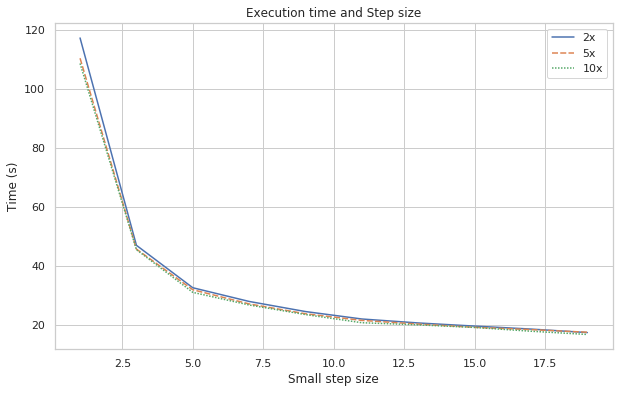

In [34]:
data = pd.DataFrame(times[1:].T, index=small_step_sizes, columns=['2x', '5x','10x'])

plt.figure(figsize=(10,6))

ax = sns.lineplot(data=data)
ax.set(xlabel='Small step size', ylabel='Time (s)')
ax.set_title("Execution time and Step size")

## Save videos

In [39]:
n, m = 50, 10

face_tracker = FaceTracker(
    image_size=160, 
    ref_paths=ref_paths, 
    batch_size=8, 
    step_large=n, 
    step_small=m
)

faces_dict = face_tracker.detect(video_path)


frames_tracked = []
for i, frame in enumerate(frames):
    
    faces = faces_dict[i]
    
    boxes = [face.bbox for face in faces]
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    
    if boxes is None:
        continue
    for box in boxes:
            draw.rectangle(box, outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')   

save_path = f'../../tests/data/Elon Musk/small_{m}-large_{n}.mp4'
video_tracked = cv2.VideoWriter(save_path, fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()